In [1]:
# CTA_STEP 3 (Public goods game data)
# Allocate pos/neg words to topics

In [2]:
#import packages
import re
import numpy as np
import pandas as pd
import random

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess

# spacy for lemmatization
import spacy

# Plotting tools

import matplotlib.pyplot as plt


# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)



from gensim.models import Word2Vec


import random

import statsmodels.api as sm
import shap

from nltk.tokenize import RegexpTokenizer

from nltk.tokenize.treebank import TreebankWordDetokenizer


import copy
from gensim.models import KeyedVectors

from itertools import combinations

import nltk

from itertools import combinations
from itertools import product

from sklearn.feature_extraction.text import CountVectorizer

from gensim.models import FastText

from scipy.stats import sem
import scipy as sp

from scipy import stats

In [3]:
# Preprosessing is necessary because some steps make reference to the text data
# Step 0: data cleaning

In [4]:
np.random.seed(42)
random.seed(42)

In [5]:
# load data
path_data=""
path_graphs=""

df = pd.read_csv(path_data+"tdm1011_metadata.csv",sep=",",dtype=str)

df.head(5)

,name,path,Unnamed: 2,age,belief.in.god,condition_number,contribution,correct.crt.answers,country.of.residence..232.us.,datelastaction,...,social.risk.taking,strategy.description,time.delay,time.pressure,time.reading.instructions,time_pred,txtorg_id,us.resident,what.cont.maximizes.group.payoff,what.cont.maximizes.your.payoff
0,NaN,NaN,154,22,1,10,40,3,232,4/26/12 3:56,...,3.6,"basically, given the choices of how much to co...",0,0,71,na,4cf9192e-7591-11e2-89cc-88532e617cea,1,40,40
1,NaN,NaN,155,24,1,10,30,0,232,4/27/12 23:15,...,3.2,i felt like it was the right decision. i had a...,0,0,72,na,4cfa2db4-7591-11e2-89cc-88532e617cea,1,0,0
2,NaN,NaN,157,25,1,10,40,3,232,4/26/12 22:48,...,3.4,don't believe,0,0,36,na,4cfaf9ec-7591-11e2-89cc-88532e617cea,1,40,40
3,NaN,NaN,158,24,9,10,40,1,203,4/24/12 12:39,...,2.9,main reason for my contribution was the the fe...,0,0,104,na,4cfb1634-7591-11e2-89cc-88532e617cea,0,40,0
4,NaN,NaN,159,26,10,10,0,2,129,4/27/12 22:51,...,2.1,because i want to take a risk.,0,0,165,na,4cfb3dd0-7591-11e2-89cc-88532e617cea,0,40,0


In [6]:
# identify text and ourcome
df['treatment']=pd.to_numeric(df['primed.for.intuition'])
text=df['strategy.description']
outcome=df['treatment']
text_original=df['strategy.description']
metadata=df[['education','female','contribution','normalized.contribution']]

In [7]:
def sent_to_words_orig(sentences):
    for sentence in sentences:
        yield(str(sentence).split())

# remove stopwords

# Load the spacy model (for other languages, use another spacy model)
nlp = spacy.load('en_core_web_sm')

text = text.apply(lambda x: ' '.join([token.text for token in nlp(x) if not token.is_stop]))

# lemmatize text (optional)

text_lemma = text.apply(lambda x: ' '.join([token.lemma_ for token in nlp(x)]))

df_tosave=pd.DataFrame({'text':text_lemma,'treatment':outcome, 'text_raw':text, 'text_original':text_original})
df_tosave = pd.concat([df_tosave, metadata], axis=1)
df_tosave = df_tosave[df_tosave['text'].str.len() > 0].reset_index(drop=True)

text_lemma=df_tosave['text']
outcome=df_tosave['treatment']
text_orig=df_tosave['text_raw']


words = text_lemma.apply(nltk.word_tokenize)
words_orig = text_orig.apply(nltk.word_tokenize)

# Flatten the list of words
words = [word for sublist in words for word in sublist]
words_orig = [word for sublist in words_orig for word in sublist]

# Create a frequency distribution
freqdist = nltk.FreqDist(words)

sorted_freqdist = sorted(freqdist.items(), key=lambda x: x[1],reverse=True)

# Create a frequency distribution
freqdist_orig = nltk.FreqDist(words_orig)

sorted_freqdist_orig = sorted(freqdist_orig.items(), key=lambda x: x[1],reverse=True)

# Define minimum number of characters
min_characters = 3

# Assuming text_lemma is your lemmatized text
vectorizer = CountVectorizer(min_df=1, token_pattern=r'\b\w{%d,}\b' % min_characters)

# fit the vectorizer on the lemmatized text
X = vectorizer.fit_transform(text_lemma)

# X is a sparse matrix representing the bag-of-words model
# To get the feature names (words), you can use
feature_names = vectorizer.get_feature_names_out()

# To convert the matrix into a DataFrame:
# Here, feature_names (which are your words) are used as column names in the DataFrame
bow_df = pd.DataFrame(X.toarray(), columns=feature_names)

data_words = list(sent_to_words_orig(text_lemma))

data_words_orig = list(sent_to_words_orig(text_orig))

In [8]:
df_tosave.to_csv(path_data+'tdm_lemmatized.csv',index=False)

In [9]:
# functions necessary for Step 3

def similarity_cosine(vec1, vec2):
    cosine_similarity = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
    return cosine_similarity

def create_cosine_matrix(pretrained_model, word_list):
    vocab_index = pd.DataFrame({'feature_names':word_list,'feature_index':range(1,len(word_list)+1)})
    all_words_dict = {a: x-1 for a, x in vocab_index.values}
    word_index = all_words_dict
    EMBED_DIM = 300
    words_not_found = []
    nb_words = len(word_index)
    embedding_matrix = np.zeros((nb_words, EMBED_DIM))
    emb_name = []
    index = 0
    for word, i in word_index.items():
        if i >= nb_words:
            continue
        try:
            embedding_vector = pretrained_model.wv[word]
        except KeyError:
            embedding_vector = None
        if (embedding_vector is not None) and len(embedding_vector) > 0:
            embedding_matrix[index] = embedding_vector
            emb_name.append(word)
            index = index + 1
        else:
            words_not_found.append(word)
    if words_not_found != []:
        print(f"Null word embeddings: {np.sum(np.sum(embedding_matrix, axis=1) == 0)}")
        print(f"Some of the words not found:\n{' '.join([random.choice(words_not_found) for x in range(0,10)])}")
    n_words_notfound = embedding_matrix.shape[0] - len(emb_name)
    embedding_matrix = np.delete(embedding_matrix, range(embedding_matrix.shape[0] - len(words_not_found), embedding_matrix.shape[0]), 0)
    embedding_matrix_names = pd.DataFrame(np.transpose(embedding_matrix))
    embedding_matrix_names.columns = emb_name
    cosine_matrix = pd.DataFrame(np.zeros((len(emb_name), len(emb_name))), columns=emb_name, index=emb_name)
    for i in range(cosine_matrix.shape[1]):
        word_1 = cosine_matrix.columns[i]
        for j in range(cosine_matrix.shape[1]):
            word_2 = cosine_matrix.index[j]
            cosine_matrix.iloc[j, i] = similarity_cosine(embedding_matrix_names[word_1], embedding_matrix_names[word_2])
    return cosine_matrix



def calculate_quality_all(words_per_topic, cosine_matrix):
    quality_all_tmp = []
    topic_combinations = list(combinations(range(len(words_per_topic)), 2))
    for i in range(len(topic_combinations)):
        topic_k = topic_combinations[i][0]
        topic_l = topic_combinations[i][1]
        topic_k_words = words_per_topic[topic_k]
        topic_k_words_combinations = list(combinations(topic_k_words, 2))
        topic_l_words = words_per_topic[topic_l]
        topic_l_words_combinations = list(combinations(topic_l_words, 2))

        # coherence_k
        tmp_intra_topic_k = list(combinations(topic_k_words, 2))
        coherence_k = []
        for j in range(len(tmp_intra_topic_k)):
            coherence_tmp = cosine_matrix.loc[topic_k_words_combinations[j][1], topic_k_words_combinations[j][0]]
            coherence_k.append(coherence_tmp)
        coherence_k = np.mean(coherence_k)

        # coherence_l
        tmp_intra_topic_l = list(combinations(topic_l_words, 2))
        coherence_l = []
        for j in range(len(tmp_intra_topic_l)):
            coherence_tmp = cosine_matrix.loc[topic_l_words_combinations[j][1], topic_l_words_combinations[j][0]]
            coherence_l.append(coherence_tmp)
        coherence_l = np.mean(coherence_l)

        # diversity k_l
        topic_k_l_combinations = list(product(topic_k_words, topic_l_words))
        diversity_k_l_combs = []
        for k in range(len(topic_k_l_combinations)):
            diversity_k_l_tmp = cosine_matrix.loc[topic_k_l_combinations[k][1], topic_k_l_combinations[k][0]]
            diversity_k_l_combs.append(diversity_k_l_tmp)
        diversity_k_l = 1 - np.mean(diversity_k_l_combs)

        quality_k_l = (coherence_k + coherence_l) / 2 * diversity_k_l
        quality_all_tmp.append(quality_k_l)

    if len(quality_all_tmp) > 0:
        quality_all = np.mean(quality_all_tmp)
    else:
        quality_all = 0

    return quality_all


def optimize_clusters(grid_alpha, grid_delta, word_importance, cosine_matrix):
    median_distance = np.median(cosine_matrix)
    interpretability_matrix = np.zeros((len(grid_delta), len(grid_alpha)))
    index_m = 0
    for m in grid_delta:
        delta = m
        index_n = 0
        for n in grid_alpha:
            min_distance = median_distance * n
            words_to_drop = []
            cluster_list_groups = []
            mean_shap = []
            impact_shap = []
            word_importance_clustering = word_importance[word_importance['Variable'].isin(words_to_drop) == False].reset_index(drop=True)
            while len(word_importance_clustering) > 1:
                word_start = word_importance_clustering['Variable'].loc[0]
                cosine_matrix_tmp = cosine_matrix.copy()
                cosine_matrix_tmp.drop(words_to_drop, inplace=True, axis=0)
                cosine_matrix_tmp.drop(words_to_drop, inplace=True, axis=1)
                word_closest = cosine_matrix_tmp[word_start].nlargest(2).index[1]
                dist_init = cosine_matrix_tmp[word_start].nlargest(2)[1]
                if dist_init > min_distance:
                    mean_dist_words = (cosine_matrix_tmp[word_start] + cosine_matrix_tmp[word_closest]) / 2
                    dist_threshold = dist_init * delta
                    cluster_list_tmp = [word_start, word_closest]
                    dist_words = 1
                    while (dist_words > dist_threshold) & (len(cosine_matrix_tmp) > len(cluster_list_tmp)):
                        mean_dist_words = cosine_matrix_tmp[cluster_list_tmp].mean(axis=1)
                        mean_dist_words.drop(cluster_list_tmp, inplace=True)
                        word_add = mean_dist_words.nlargest(2).index[0]
                        dist_words = mean_dist_words.nlargest(2)[0]
                        cluster_list_tmp.append(word_add)
                    words_to_drop.extend(cluster_list_tmp)
                    cluster_list_groups.append(cluster_list_tmp)
                    word_importance_clustering = word_importance[word_importance['Variable'].isin(words_to_drop) == False].reset_index(drop=True)
                else:
                    words_to_drop.extend([word_start])
                    word_importance_clustering = word_importance[word_importance['Variable'].isin(words_to_drop) == False].reset_index(drop=True)
            quality_all = calculate_quality_all(cluster_list_groups, cosine_matrix)
            log_nwords = np.log(len([item for sublist in cluster_list_groups for item in sublist]) + 1)
            interpretability = log_nwords * quality_all
            interpretability_matrix[index_m, index_n] = interpretability
            index_n = index_n + 1
        index_m = index_m + 1
    ind = np.unravel_index(np.argmax(interpretability_matrix, axis=None), interpretability_matrix.shape)
    delta = grid_delta[ind[0]]
    alpha = grid_alpha[ind[1]]
    return alpha, delta



def calculate_clusters(method, n_clusters, delta, alpha, cosine_matrix, word_importance):
    words_to_drop = []
    cluster_list_groups = []
    mean_shap = []
    impact_shap = []
    mean_dist_words_topics = []

    median_distance = np.median(cosine_matrix)
    min_distance = alpha * median_distance
    word_importance_clustering = word_importance[word_importance['Variable'].isin(words_to_drop) == False].reset_index(drop=True)

    while len(word_importance_clustering) > 1:
        word_start = word_importance_clustering['Variable'].loc[0]

        cosine_matrix_tmp = cosine_matrix.copy()
        cosine_matrix_tmp.drop(words_to_drop, inplace=True, axis=0)
        cosine_matrix_tmp.drop(words_to_drop, inplace=True, axis=1)

        word_closest = cosine_matrix_tmp[word_start].nlargest(2).index[1]
        dist_init = cosine_matrix_tmp[word_start].nlargest(2)[1]
        if dist_init > min_distance:
            mean_dist_words = (cosine_matrix_tmp[word_start] + cosine_matrix_tmp[word_closest]) / 2

            dist_threshold = dist_init * delta

            cluster_list_tmp = [word_start, word_closest]

            dist_words = 1
            while (dist_words > dist_threshold) & (len(cosine_matrix_tmp) > len(cluster_list_tmp)):
                mean_dist_words = cosine_matrix_tmp[cluster_list_tmp].mean(axis=1)
                mean_dist_words.drop(cluster_list_tmp, inplace=True)
                word_add = mean_dist_words.nlargest(2).index[0]
                dist_words = mean_dist_words.nlargest(2)[0]
                cluster_list_tmp.append(word_add)
            words_to_drop.extend(cluster_list_tmp)
            cluster_list_groups.append(cluster_list_tmp)
            mean_dist_words_topics_tmp=np.mean(cosine_matrix_tmp[cluster_list_tmp])
            if method != 'freq_only':
                mean_dist_words_topics.append(mean_dist_words_topics_tmp)
                mean_shap.append(word_importance[word_importance['Variable'].isin(cluster_list_tmp)]['word_importance_abs'].mean())
                impact_shap.append(word_importance[word_importance['Variable'].isin(cluster_list_tmp)]['impact'].mean())
            word_importance_clustering = word_importance[word_importance['Variable'].isin(words_to_drop) == False].reset_index(drop=True)
        else:
            words_to_drop.extend([word_start])
            word_importance_clustering = word_importance[word_importance['Variable'].isin(words_to_drop) == False].reset_index(drop=True)

    n_cluster_index = len(cluster_list_groups)
    if n_cluster_index < n_clusters:
        n_clusters_to_use = n_cluster_index
    else:
        n_clusters_to_use = n_clusters

    if method == 'freq_only':
        index_clusters = range(n_clusters_to_use)
    elif method == 'top_shap':
        index_clusters = range(n_clusters_to_use)
    elif method == 'mean_shap':
        index_clusters = np.argpartition(mean_shap, -n_clusters_to_use)[-n_clusters_to_use:]
    elif method == 'impact':
        index_clusters = np.argpartition(impact_shap, -n_clusters_to_use)[-n_clusters_to_use:]
    elif method == 'coherence':
        index_clusters = np.argpartition(mean_dist_words_topics, -n_clusters_to_use)[-n_clusters_to_use:]

    cluster_list_groups = [cluster_list_groups[l] for l in index_clusters]


    return cluster_list_groups, n_cluster_index 


In [10]:
# create word embeddings for clustering

# Load pre-trained model
pretrained_model = FastText.load_fasttext_format("cc.en.300.bin")

# Update the model with new data

pretrained_model.build_vocab(corpus_iterable=data_words, update=True)
pretrained_model.train(corpus_iterable=data_words, total_examples=len(data_words), epochs=pretrained_model.epochs)

(410, 2154)

In [11]:
# load SHAP values

shap_allwords=pd.read_csv("tdm_intuition_shap_bert_allwords_220324_train_lemma_shap_lemma.csv")

# copy to new dataframe 
shap_values_matrix=shap_allwords.copy()

In [12]:
shap_values_matrix

,group,cooperate,rational,greedy,produce,intelligent,mind,way,polite,cour,...,logical,interact,admit,outcome,safe,i.e,happy,retu,sacrificing,atheist
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,-0.123708,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
244,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-0.009692,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
245,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
246,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
#calculate shap mean value and perform t-test
feature_importance = pd.DataFrame({
    'Variable': shap_values_matrix.columns,
    'word_importance': shap_values_matrix.mean(),
    'word_se': sem(shap_values_matrix),
    'word_tval': [stats.ttest_1samp(shap_values_matrix[col], 0)[0] for col in shap_values_matrix.columns],
    'word_pval': [stats.ttest_1samp(shap_values_matrix[col], 0)[1] for col in shap_values_matrix.columns]
}).reset_index(drop=True)
feature_importance = feature_importance.fillna(0)


feature_importance['word_importance_abs']=abs(feature_importance['word_importance'])

freqlist=[]
for i in feature_importance['Variable']:
    if len([item for item in sorted_freqdist if item[0] == i])>0:
        freqlist.append([item for item in sorted_freqdist if item[0] == i][0][1])
    else:
        freqlist.append(0)
        
feature_importance['freq']=freqlist
feature_importance['impact']=feature_importance['freq']*feature_importance['word_importance_abs']



In [14]:
# create descending list with top words for pos/neg, with p-value for SHAP>0 below 0.1
feature_importance_pos=feature_importance[(feature_importance['word_pval']<0.1)&
                                          (feature_importance['word_importance']>0)].reset_index(drop=True)

feature_importance_neg=feature_importance[(feature_importance['word_pval']<0.1)&
                                          (feature_importance['word_importance']<0)].reset_index(drop=True)

feature_importance_pos=feature_importance_pos.sort_values('word_importance_abs',ascending=False).reset_index(drop=True)
feature_importance_neg=feature_importance_neg.sort_values('word_importance_abs',ascending=False).reset_index(drop=True)

#feature_importance_pos=feature_importance_pos.sort_values('word_pval',ascending=True).reset_index(drop=True)
#feature_importance_neg=feature_importance_neg.sort_values('word_pval',ascending=True).reset_index(drop=True)
#feature_importance_pos=feature_importance_pos.sort_values('impact',ascending=False).reset_index(drop=True)
#feature_importance_neg=feature_importance_neg.sort_values('impact',ascending=False).reset_index(drop=True)


In [15]:
feature_importance_pos

,Variable,word_importance,word_se,word_tval,word_pval,word_importance_abs,freq,impact
0,good,0.006369,0.001354,4.701949,0.000004,0.006369,47,0.299325
1,feel,0.005762,0.001436,4.011916,0.000080,0.005762,25,0.144042
2,hope,0.005610,0.001212,4.627092,0.000006,0.005610,25,0.140248
3,bonus,0.001304,0.000468,2.784304,0.005780,0.001304,14,0.018260
4,trust,0.001247,0.000602,2.072907,0.039218,0.001247,10,0.012473
5,gamble,0.001159,0.000506,2.290893,0.022812,0.001159,6,0.006952
6,god,0.000846,0.000428,1.977533,0.049093,0.000846,7,0.005920
7,self,0.000550,0.000256,2.145682,0.032873,0.000550,7,0.003852
8,well,0.000504,0.000305,1.651641,0.099879,0.000504,9,0.004536
9,play,0.000180,0.000094,1.905138,0.057923,0.000180,4,0.000719


In [16]:
# Create distance matrices
cosine_matrix_pos=create_cosine_matrix(pretrained_model,feature_importance_pos['Variable'])

cosine_matrix_neg=create_cosine_matrix(pretrained_model,feature_importance_neg['Variable'])

In [17]:
# find optimal alpha and delta and use optimal values to create clusters
grid_alpha=np.arange (0.4, 4, 0.2)
grid_delta=np.arange (0.4, 1, 0.1)

alpha, delta = optimize_clusters(grid_alpha, grid_delta, feature_importance_pos, cosine_matrix_pos)
print(alpha, delta)
cluster_list_groups_pos, n_cluster_index_pos = calculate_clusters('top_shap', 2, delta, alpha, cosine_matrix_pos, feature_importance_pos)


alpha, delta = optimize_clusters(grid_alpha, grid_delta, feature_importance_neg, cosine_matrix_neg)
print(alpha, delta)
cluster_list_groups_neg, n_cluster_index_neg = calculate_clusters('top_shap', 2, delta, alpha, cosine_matrix_neg, feature_importance_neg)

1.2000000000000002 0.7
1.6000000000000005 0.8999999999999999


In [18]:
# total number of clusters for pos/neg

print(n_cluster_index_pos)
print(n_cluster_index_neg)

3
10


In [19]:
# print top (as specified in calculate_clusters function above) clusters
print('positive:')
print(cluster_list_groups_pos)
print('negative:')
print(cluster_list_groups_neg)

positive:
[['good', 'well', 'hope'], ['feel', 'trust', 'self', 'god']]
negative:
[['contribute', 'contribution', 'benefit'], ['group', 'participant', 'person', 'people', 'thing']]


The rest of the notebook computes different validations of the model

In [20]:
# calcluate quality for top clusters

quality_pos=calculate_quality_all(cluster_list_groups_pos, cosine_matrix_pos)
print('quality positive:')
print(quality_pos)


quality_neg=calculate_quality_all(cluster_list_groups_neg, cosine_matrix_neg)
print('quality negative:')
print(quality_neg)

quality positive:
0.23724499490294076
quality negative:
0.3458997356469264


In [21]:
# Create dummy variables for each sublist in cluster_list_groups_pos
for i, sublist in enumerate(cluster_list_groups_pos, start=1):
    var_name = f'topic pos {i}'
    globals()[var_name] = text_lemma.apply(lambda x: any(word in x for word in sublist)).astype(int)
    
for i, sublist in enumerate(cluster_list_groups_neg, start=1):
    var_name = f'topic neg {i}'
    # Create a dummy variable for each sublist
    globals()[var_name] = text_lemma.apply(lambda x: any(word in x for word in sublist)).astype(int)

# Now you can access the variables like topic_pos_1, topic_pos_2, etc.

# Create a DataFrame with the topic dummies and the variable "outcome"
df_reg = pd.DataFrame()
for i in range(1, len(cluster_list_groups_pos) + 1):
    df_reg[f'topic pos {i}'] = globals()[f'topic pos {i}']
for i in range(1, len(cluster_list_groups_neg) + 1):
    df_reg[f'topic neg {i}'] = globals()[f'topic neg {i}']
df_reg['outcome'] = outcome

df_reg.describe()

,topic pos 1,topic pos 2,topic neg 1,topic neg 2,outcome
count,248.000000,248.000000,248.000000,248.000000,248.000000
mean,0.274194,0.213710,0.326613,0.395161,0.479839
std,0.447009,0.410753,0.469923,0.489874,0.500604
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [22]:
# create a variable for each topic with the total shap value for all words in topic per answer

for i, sublist in enumerate(cluster_list_groups_pos, start=1):
    var_name = f'topic pos {i}'
    globals()[var_name] = shap_values_matrix[sublist].sum(axis=1)
    
for i, sublist in enumerate(cluster_list_groups_neg, start=1):
    var_name = f'topic neg {i}'
    globals()[var_name] = shap_values_matrix[sublist].sum(axis=1)

In [28]:
# Create a DataFrame with the topic weights and the variable "outcome"
df_reg = pd.DataFrame()
for i in range(1, len(cluster_list_groups_pos) + 1):
    df_reg[f'Intuition Topic {i}'] = globals()[f'topic pos {i}']
for i in range(1, len(cluster_list_groups_neg) + 1):
    df_reg[f'Reflection Topic {i}'] = globals()[f'topic neg {i}']*(-1)
df_reg['outcome'] = outcome


In [29]:
# Convert DataFrame to numeric data type
df_reg = df_reg.apply(pd.to_numeric, errors='coerce')

# Store coefficients and confidence intervals
coefficients = []
conf_intervals = []

# Run a linear regression for each topic dummy
for column in df_reg.columns:
    if column != 'outcome':
        X = df_reg['outcome']
        y = df_reg[column]
        X = sm.add_constant(X)  # adding a constant

        model = sm.OLS(y, X).fit()
        coefficients.append(model.params[1])
        conf_intervals.append(model.conf_int(alpha=0.1).iloc[1].values)


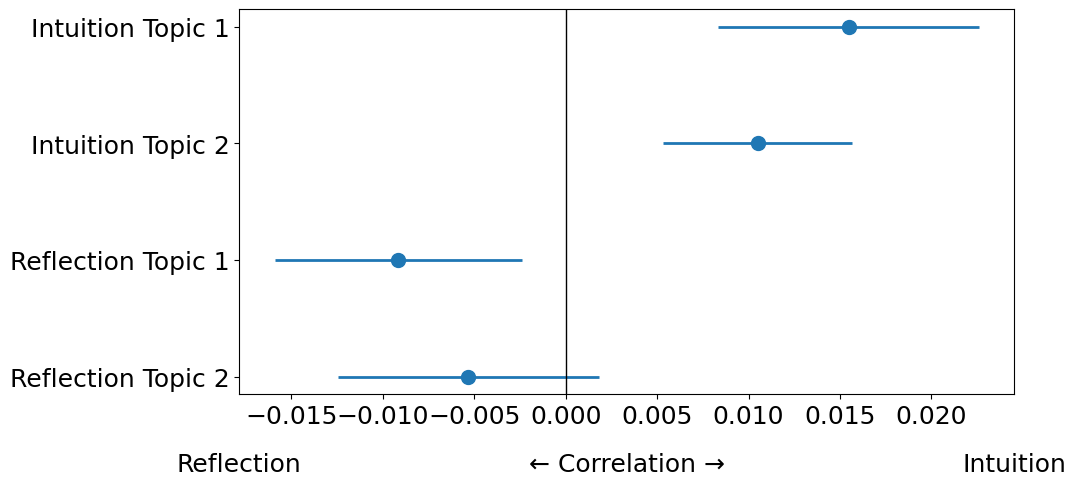

In [53]:
# Plot coefficients with confidence intervals
# Define your desired font size and marker size
font_size = 18
marker_size = 10
line_width = 2

# Plot coefficients with confidence intervals
plt.figure(figsize=(10, 5))
topic_order=np.arange(len(coefficients),0,-1)-1
# Plot error bars with increased marker size and line width
plt.errorbar(coefficients, topic_order, 
             xerr=[abs((top-bot)/2) for top, bot in conf_intervals],
             fmt='o', markersize=marker_size, elinewidth=line_width)

# Increase font size for y-axis labels
plt.yticks(topic_order, df_reg.columns[df_reg.columns != 'outcome'], fontsize=font_size)

# Get the current limits of the x-axis
xmin, xmax = plt.xlim()

# Define x-axis labels and their positions
labels = ['Reflection', u'\u2190 Correlation \u2192', 'Intuition']  # Unicode characters for left and right arrows
positions = [xmin, (xmin + xmax) / 2, xmax]  # Place 'Correlation' at the middle of the x-axis

# Add new x-axis labels
for pos, label in zip(positions, labels):
    plt.text(pos, -0.15, label, fontsize=font_size, ha='center', va='top', transform=plt.gca().get_xaxis_transform())

# Increase font size for original x-axis labels
plt.xticks(fontsize=font_size)

plt.axvline(x=0, color='black', linewidth=1)


plt.savefig(path_graphs+'cta_topic_treatment_tdm.png',bbox_inches='tight')
plt.show()

In [54]:
# quality for all topics
cluster_list_groups_all=cluster_list_groups_pos+cluster_list_groups_neg

# Flatten the list of lists into a single list
all_words_cluster_list_groups_all = [word for sublist in cluster_list_groups_all for word in sublist]
# Remove duplicates by converting the list to a set
unique_words = set(all_words_cluster_list_groups_all)

# Convert the set back to a list
all_words_cluster_list_groups_all = list(unique_words)

cosine_matrix_alltopics = create_cosine_matrix(pretrained_model, all_words_cluster_list_groups_all)
round(calculate_quality_all(cluster_list_groups_all, cosine_matrix_alltopics),2)

0.3